In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('./release_nano/')

In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

C:\Users\PC1\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_cuda = torch.cuda.is_available()
use_cuda

False

In [4]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from util import canonical_smiles

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
#没有这句话需要加上plt.show()才能显示画图
import seaborn as sns

In [6]:
gen_data_path = './SupplementaryData_AuAgPtPd.smi'

In [7]:
tokens = ['<', '>' ,'#', ')', '(', '[',']','{','}','@',':','*','+', '-', '/',',', '.', '1', '0', '3', '2', '5', '4', '7','T',
          '6', '9', '8', '=', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L', 'M', 'N', '[', ']',
          'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W','X', 'Y', 'Z','r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
          '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm','n', 'o', 'p', '-']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [8]:
def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted pIC50', 
           title='Distribution of predicted pIC50 for generated molecules')
    plt.show()

In [9]:
hidden_size = 300
stack_width = 300
stack_depth = 250
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta


my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

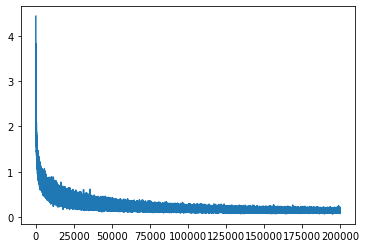

In [13]:
plt.plot(losses)
plt.savefig('Training loss.png', dpi=300)

In [10]:
import os
print(os.getcwd())

d:\Desktop\task0\generate\generate20220707


In [11]:
model_path = './model/checkpoint_biggest_rnn'


In [12]:
my_generator.evaluate(gen_data)

d:\Desktop\task0\generate\generate20220707\./release_nano\data.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor)


'<ZZv4-L,\\sWYKyi9d++UOZgd7}o(th*xGTLCK.lh1Ko[,m@3T0[8-YS+pm\\Y9ibhsv(tcVb7Ko8XfTO+ITM1:3zTt9T5sVUDooB\\Z'

In [22]:
def estimate_and_update(generator, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=200)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
#     smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
#     plot_hist(prediction, n_to_generate)
        
    return unique_smiles
